In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Exercise 4: Binomial Tree

In [2]:
def binary_pricing(s0,k,r,sigma,step,T,call_bool,greeks = '',type = 'European'):
    #basing on Cox-Ross-Rubinstein model
    dt = T/step
    discount_float = np.exp(-r*dt)/2
    eps_float = np.exp((2*r+sigma**2)*dt)
    sq_root_float = ((1+eps_float)**2-4*np.exp(2*r*dt))**0.5
    u = discount_float*(1+eps_float+sq_root_float)
    d = discount_float*(1+eps_float-sq_root_float)
    p = (np.exp(r*dt)-d)/(u-d)
    q = 1-p
    s_array = np.zeros((step+1,step+1))
    s_array[0][0] = s0
    v_array = np.zeros((step+1,step+1))
    discount_factor_float = np.exp(-r*dt)
    for i in range(1,step+1):
        s_array[:i, i] = s_array[:i, i - 1] * u
        s_array[i, i] = s_array[i-1, i - 1] * d
    #initial payoff at maturity
    sign = 1
    if not call_bool:
        sign = -1
    for i in range(step+1):
        payoff = sign*(s_array[i][-1]-k)
        v_array[i][-1] = 0 if payoff <0 else payoff

    for i in range(step-1,-1,-1):
        if type=='European':
            v_array[:i+1,i] = discount_factor_float*(v_array[:i+1,i+1]*p+v_array[1:i+2,i+1]*q)
        elif type=='American':
            tmp = discount_factor_float*(v_array[:i+1,i+1]*p+v_array[1:i+2,i+1]*q)
            ex = sign*(s_array[:i+1,i]-k)
            ex[ex<0] = 0
            v_array[:i+1,i] = [max(tmp[l],ex[l]) for l in range(i+1)]
    if greeks=='delta':
        return (v_array[0][1]-v_array[1][1])/((u-d)*s0)
    elif greeks=='gamma':
        delta1 = (v_array[0][2]-v_array[1][2])/((u**2-u*d)*s0)
        delta2 = (v_array[1][2]-v_array[2][2])/((u*d-d**2)*s0)
        gamma = (delta1-delta2)/((u-d)*s0)
        return gamma
    return v_array[0][0]
step = 1000
K = 90
S0 = 100
sigma = 0.25
T=1
#gamma = binary_pricing(S0,K,0,sigma,step,T,True,'gamma')
def BS(s0,k,r,sigma,t,greeks = '',call_bool=True):
    sign = 1
    if not call_bool:
        sign = -1
    d1 = (np.log(s0/k)+(r+0.5*sigma**2)*(t**0.5))/(sigma*t**0.5)
    d2 = (d1-sigma*(t**0.5))
    d1*=sign
    d2*=sign

    if greeks=='delta':
        return sign*norm.cdf(d1,loc = 0,scale = 1)
    elif greeks=='gamma':
        return 1/np.sqrt(2*np.pi)*np.exp(-(d1**2)/2)/(s0*sigma*T**0.5)

    return sign*(s0*norm.cdf(d1,loc = 0,scale = 1)-k*np.exp(-r*t)*norm.cdf(d2,loc = 0,scale = 1))
#a = binary_pricing(100,90,0,0.25,1,1,True)
def cal_plot(S0,K,r,sigma,step,T,call_bool = True,info_str = '',greeks = '',type = 'European',func = binary_pricing,gap=1):
    result = list(map(func,[S0]*step,[K]*step,[r]*step,[sigma]*step,list(range(1,step+1,gap)),[T]*step,[call_bool]*step,[greeks]*step,[type]*step))
    BS_float = BS(S0,K,r,sigma,T,call_bool=call_bool)
    plt.plot(result)
    plt.plot([BS_float]*step,color = 'r',label = 'BS Price')
    plt.xlabel('steps')
    plt.ylabel('price')
    type_str = ' Call' if call_bool else ' Put'
    plt.title(f'Convergence of '+type+type_str+f' under Binary Tree with Strike :{K} Steps: {step}'+ info_str)
    plt.legend()
    plt.show()

# European Call Option
# Convergence plot against different strike

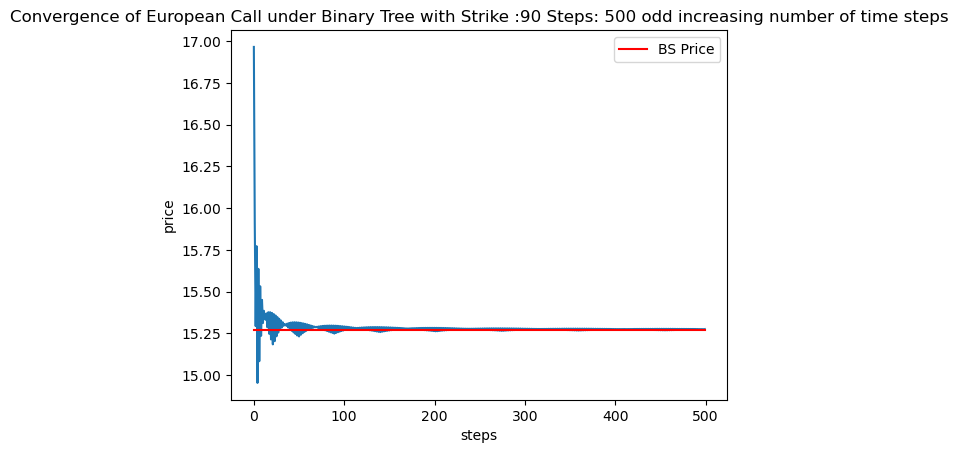

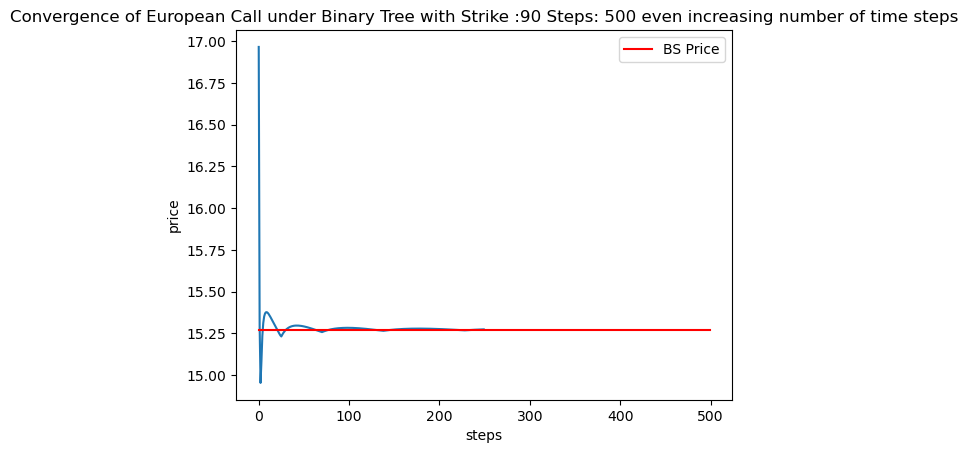

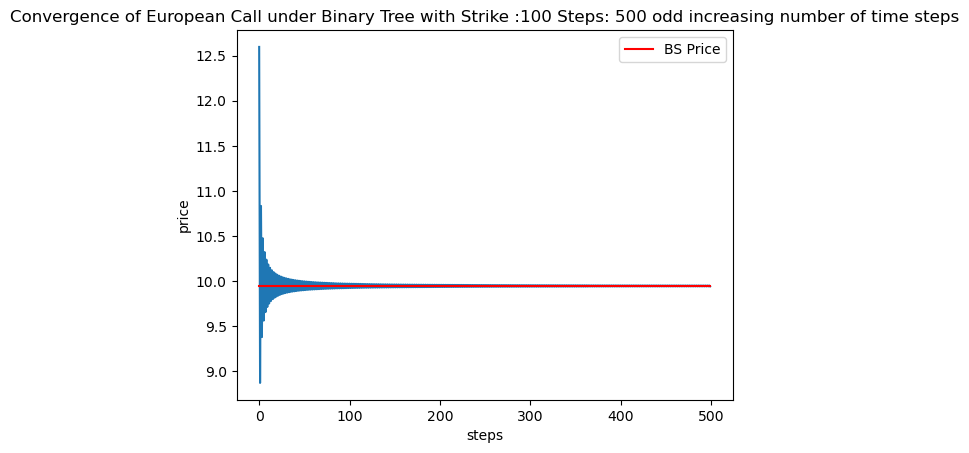

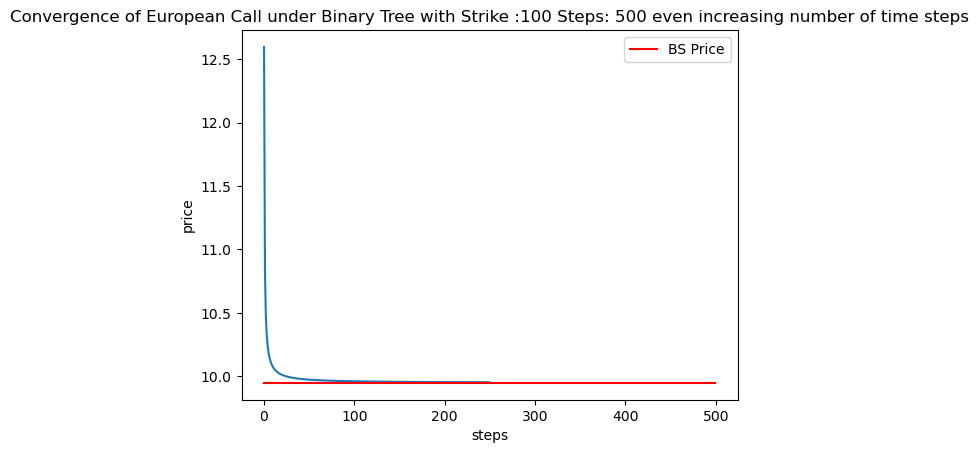

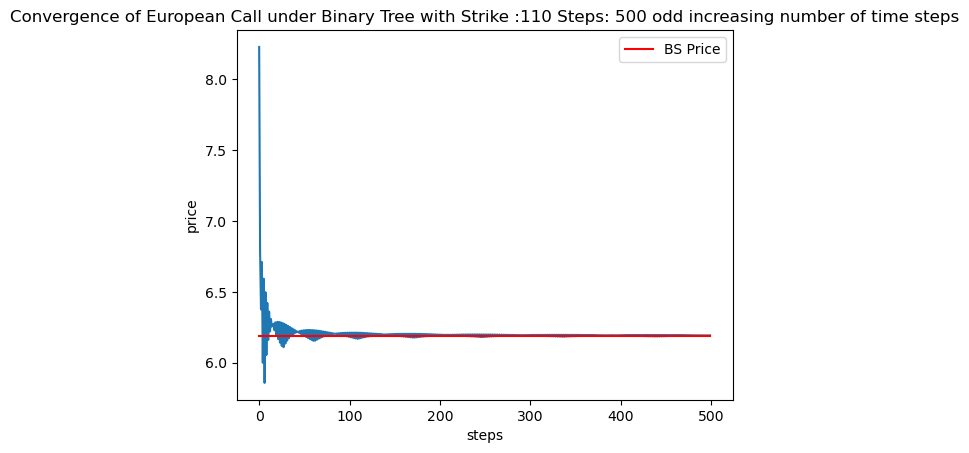

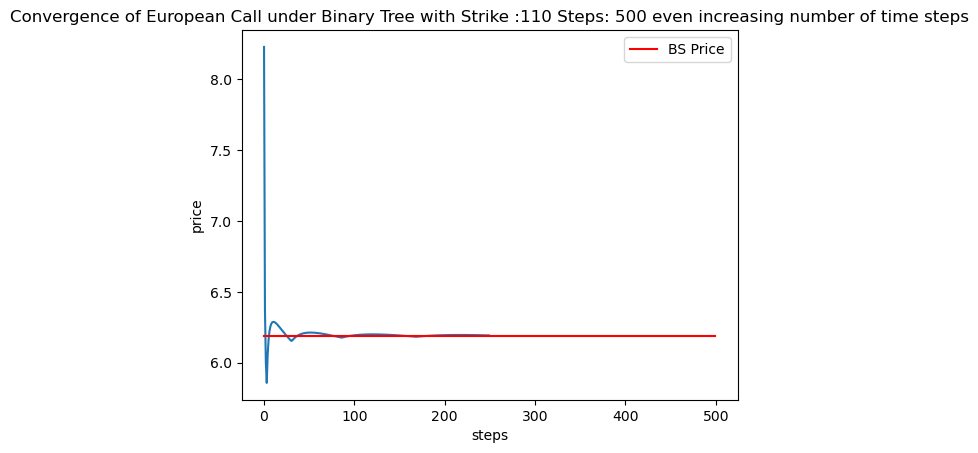

In [3]:
step = 500
K = 90
S0 = 100
sigma = 0.25
T=1
r = 0
cal_plot(S0,K,r,sigma,step,T,info_str=' odd increasing number of time steps')
cal_plot(S0,K,r,sigma,step,T,info_str=' even increasing number of time steps',gap = 2)
cal_plot(S0,100,r,sigma,step,T,info_str=' odd increasing number of time steps')
cal_plot(S0,100,r,sigma,step,T,info_str=' even increasing number of time steps',gap = 2)
cal_plot(S0,110,r,sigma,step,T,info_str=' odd increasing number of time steps')
cal_plot(S0,110,r,sigma,step,T,info_str=' even increasing number of time steps',gap = 2)

# Comments on convergence plot
#### For an at the money option, the convergence plot is nearly symmetric to price derived from BS formula. For in the money and out of the money option, the convergence plot is a little above BS price but ultimately converge to the BS price.
#### For odd increasing number of steps, there is a so-called sawtooth effect, which means that valuation result will change significantly up and down. For even increasing steps, the convergence plot is relatively smooth and even monotone when at the money.

# Greeks

In [4]:
step = 100
K = 90
S0 = 100
sigma = 0.25
T=1
r = 0

delta = binary_pricing(S0,K,0,sigma,step,T,True,'delta')
gamma = binary_pricing(S0,K,0,sigma,step,T,True,'gamma')
print(delta)
print(gamma)
BS_delta = BS(S0,K,0,sigma,T,'delta')
BS_gamma = BS(S0,K,0,sigma,T,'gamma')
print(f"BS Delta: {BS_delta}")
print(f"BS Gamma: {BS_gamma}")


0.7078951524317023
0.013814608839112983
BS Delta: 0.707618948396498
BS Gamma: 0.013744537287664688


#### After extrapolating to infinity( huge steps), both price and greeks converge to BS results

# European Put Option
# Convergence plot against different strike

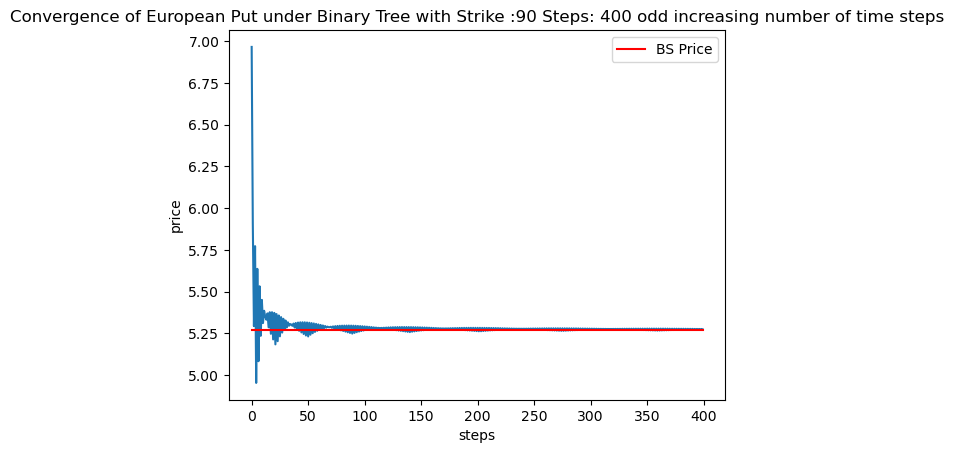

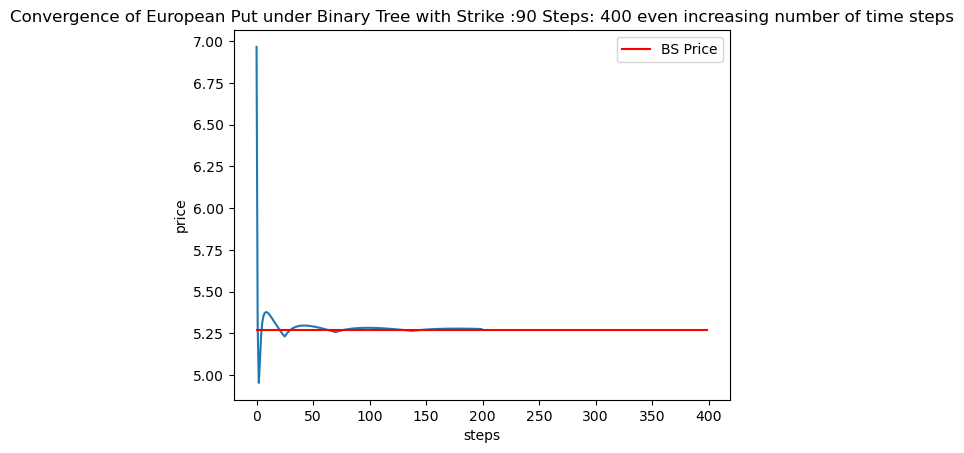

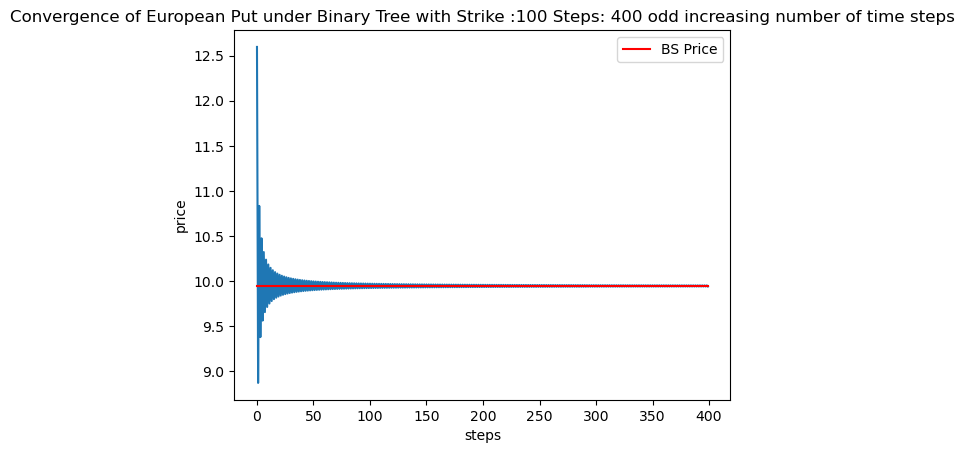

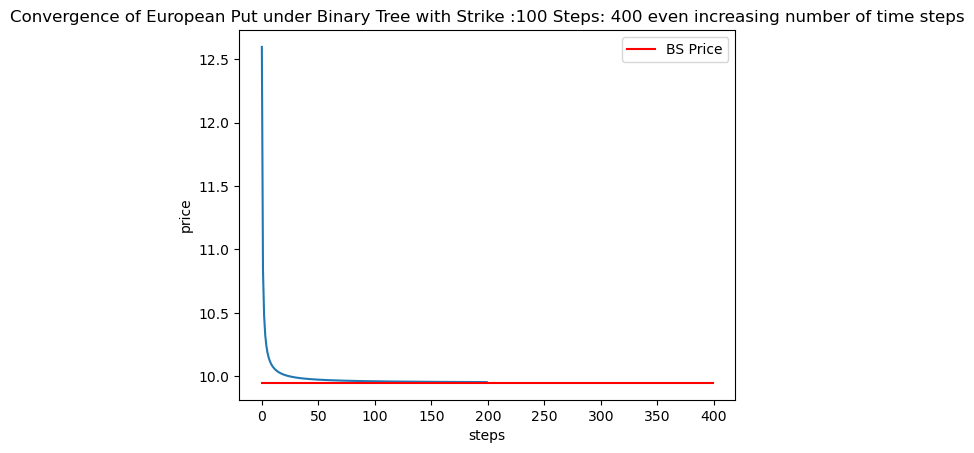

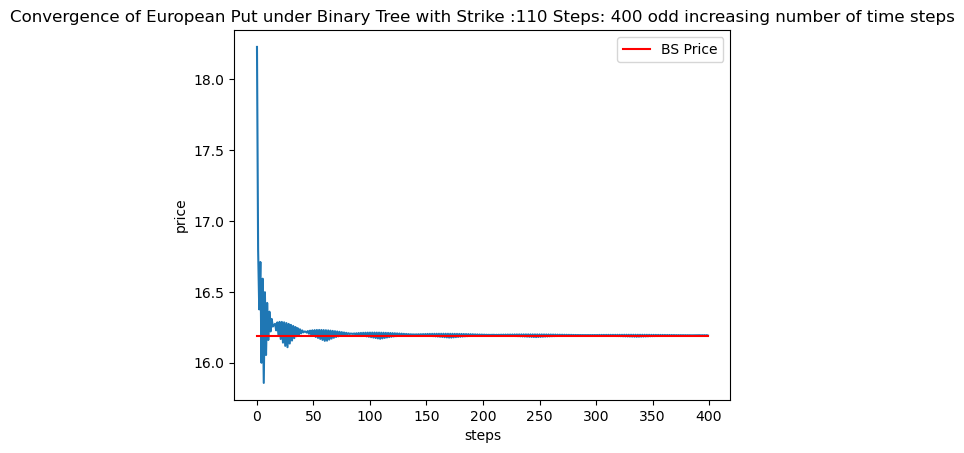

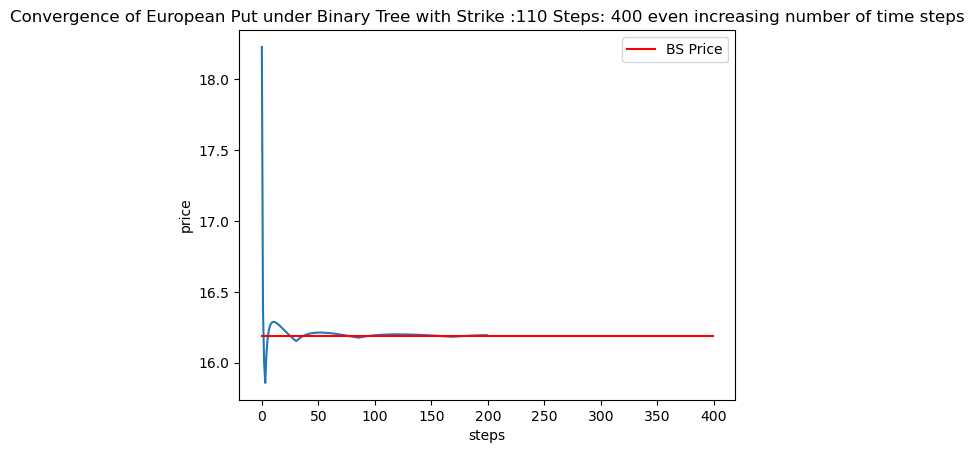

In [5]:
step = 400
K = 90
S0 = 100
cal_plot(S0,K,r,sigma,step,T,call_bool=False,info_str=' odd increasing number of time steps')
cal_plot(S0,K,r,sigma,step,T,call_bool=False,info_str=' even increasing number of time steps',gap=2)
cal_plot(S0,100,r,sigma,step,T,call_bool=False,info_str=' odd increasing number of time steps')
cal_plot(S0,100,r,sigma,step,T,call_bool=False,info_str=' even increasing number of time steps',gap=2)
cal_plot(S0,110,r,sigma,step,T,call_bool=False,info_str=' odd increasing number of time steps')
cal_plot(S0,110,r,sigma,step,T,call_bool=False,info_str=' even increasing number of time steps',gap=2)

#### The situation for Puts is the same as that for Calls in that even increasing steps result in more smooth and even monotone convergence plot instead of sawtooth effects.

# Greeks

In [6]:
step = 1000
K = 90
S0 = 100
sigma = 0.25
T=1
delta = binary_pricing(S0,K,0,sigma,step,T,False,'delta')
gamma = binary_pricing(S0,K,0,sigma,step,T,False,'gamma')
print(f"binomial Gelta: {delta}")
print(f"binomial Gamma: {gamma}")
BS_delta = BS(S0,K,0,sigma,T,call_bool=False,greeks='delta')
BS_gamma = BS(S0,K,0,sigma,T,call_bool=False,greeks='gamma')
print(f"BS Delta: {BS_delta}")
print(f"BS Gamma: {BS_gamma}")

binomial Gelta: -0.29237570299353166
binomial Gamma: 0.013748318879760565
BS Delta: -0.29238105160350203
BS Gamma: 0.013744537287664688


#### When extrapolating to infinity, both price and greeks converge to BS results.

# Exerciese 5. Trinomial tree

In [7]:
def trinomial_pricing(s0,k,r,sigma,step,T,lamb,call_bool,greeks = '',type='European'):
    if step==20:
        print('')
    sign = 1
    if not call_bool:
        sign = -1
    dt = T/step
    coef1 = 1/(2*lamb**2)
    coef2 = (r-0.5*sigma**2)/(2*lamb*sigma)*(dt**0.5)
    qu = coef1+coef2
    qd = coef1-coef2
    qm = 1-1/(lamb**2)
    b = -(np.exp(r*dt)-qm)/qu
    c = qd/qu
    a = 1
    #u = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    #d = 1/u
    u = np.exp(lamb*sigma*np.sqrt(dt))
    d = 1/u
    m = 1
    pass
    s_array = np.zeros((2*step+1,step+1))
    v_array = np.zeros((2*step+1,step+1))
    s_array[step,0] = s0
    for i in range(1,step+1):
        s_array[step-i:step+i-1,i] = s_array[step-i+1:step+i,i-1]*u
        s_array[step+i-1,i] = s_array[step+i-1,i-1]*m
        s_array[step+i,i] = s_array[step+i-1,i-1]*d
    v_array[:,-1] = sign*(s_array[:,-1]-k)
    v_array[np.where(v_array[:,-1]<0),-1] = 0
    for i in range(step-1,-1,-1):
        if type=='European':
            v_array[step-i:step+i+1,i] = (qu*v_array[step-(i+1):step+(i+1)-1,i+1]+qm*v_array[step-(i+1)+1:step+(i+1)-1+1,i+1]+qd*v_array[step-(i+1)+2:step+(i+1)-1+2,i+1])*np.exp(-r*dt)
        elif type=='American':
            tmp = (qu*v_array[step-(i+1):step+(i+1)-1,i+1]+qm*v_array[step-(i+1)+1:step+(i+1)-1+1,i+1]+qd*v_array[step-(i+1)+2:step+(i+1)-1+2,i+1])*np.exp(-r*dt)
            ex = sign*(s_array[step-i:step+i+1,i]-k)
            v_array[step-i:step+i+1,i] = [max(tmp[l],ex[l]) for l in range(2*i+1)]
    if greeks=='delta':
        return (v_array[step-1][1]-v_array[step+1][1])/((u-d)*s0)
    elif greeks=='gamma':
        delta1 = (v_array[step+2][2]-v_array[step][2])/((d*d-1)*s0)
        delta2 = (v_array[step-2][2]-v_array[step][2])/((u*u-1)*s0)
        gamma = (delta2-delta1)/((u-d)*s0)
        return gamma
    return v_array[step][0]

def tri_plot(S0,K,r,sigma,step,T,lambs,call_bool = True,greeks = '',type='European',info_str = '',func = trinomial_pricing):
    results = []
    for lamb in lambs:
        result = np.array(list(map(func,[S0]*step,[K]*step,[r]*step,[sigma]*step,list(range(1,step+1)),[T]*step,[lamb]*step,[call_bool]*step,[greeks]*step,[type]*step))).reshape(-1,1)
        results.append(result)
    results = np.concatenate(results,axis = 1)
    BS_float = BS(S0,K,r,sigma,T,call_bool=call_bool)
    plt.figure(figsize=(5,10))
    plt.plot(results,label = lambs)
    plt.plot([BS_float]*step,color = 'r',label = 'BS Price')
    plt.xlabel('steps')
    plt.ylabel('price')
    op_kind_str = ' Call' if call_bool else ' Put'

    plt.title(f'Convergence of '+type+ op_kind_str +f' under Binary Tree with Strike :{K} Steps: {step}'+ info_str,y =1.1)
    plt.legend()
    plt.show()

In [8]:
#parameter setting
step = 100
K = 90
S0 = 100
sigma = 0.25
T=1
r = 0
lambs = np.linspace(1,2,5)

# Plotting

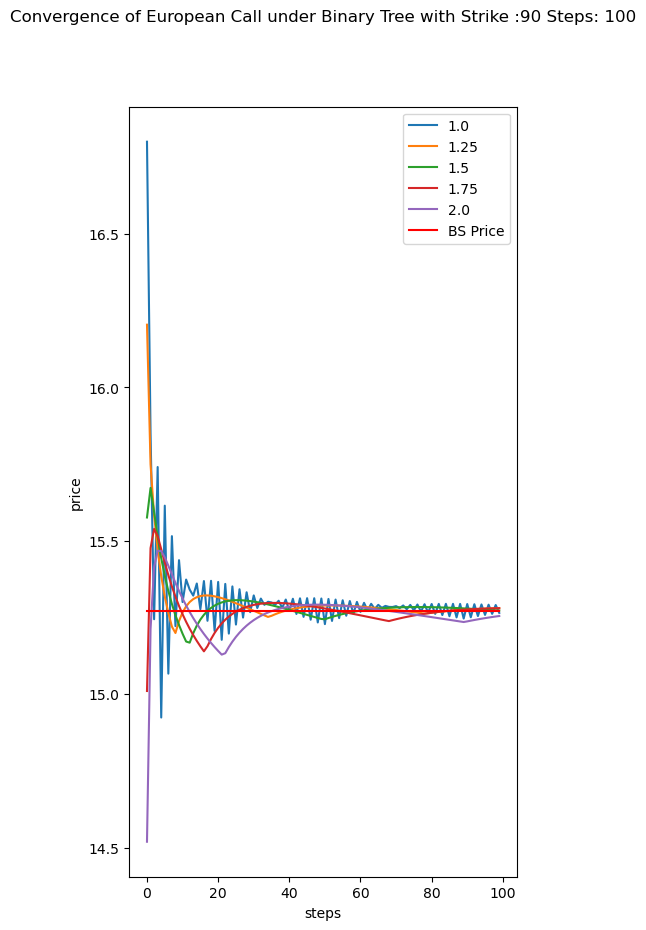

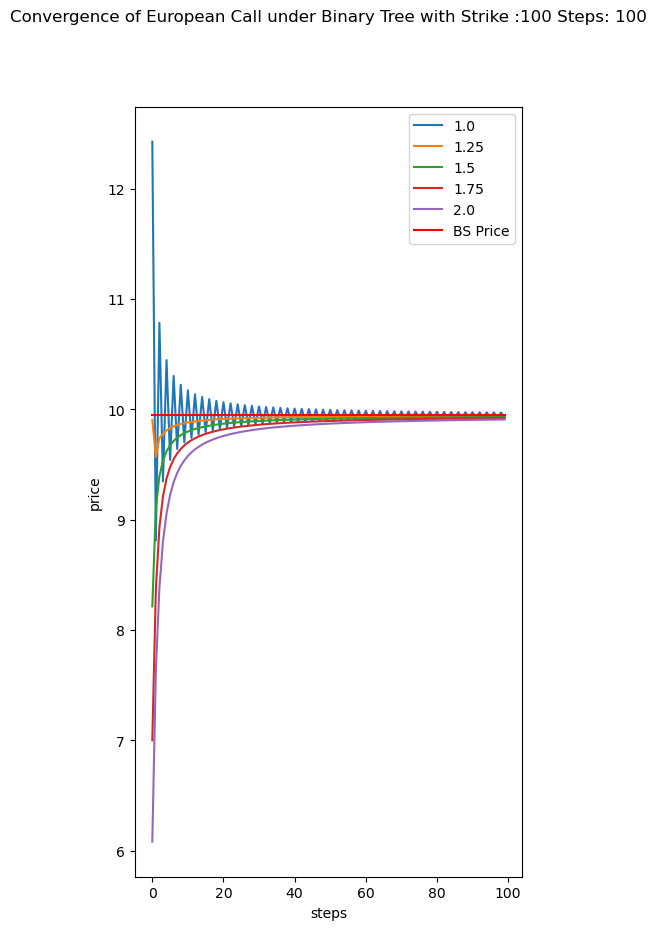

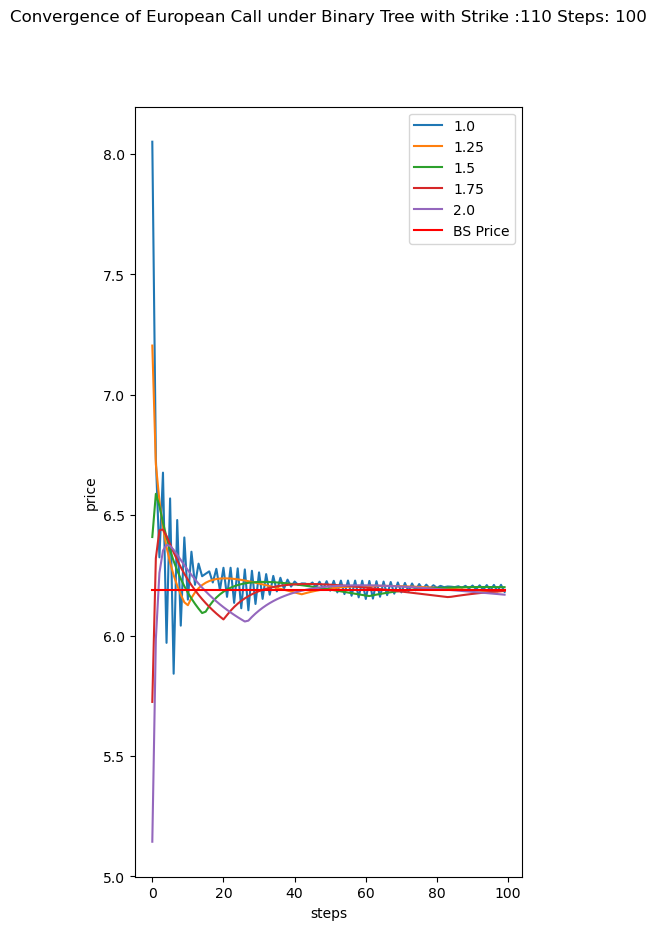

In [9]:
r1 = tri_plot(S0,K,r,sigma,step,T,lambs)
r2 = tri_plot(S0,100,r,sigma,step,T,lambs)
r3 = tri_plot(S0,110,r,sigma,step,T,lambs)

# Comments and comparison about convergence plots
#### For $\lambda > 1$, trinomial tree's converge slightly faster than binomial tree with merely no sawtooth effect like binomial tree.Smaller $\lambda$ processes tend to be more stable. Also, trinomial tree's convergence is similar to that of even increasing steps of binomial tree.
#### When calculation costs are huge, trinomial may give a faster convergence within fewer steps. If we don't care about calculation expenses, both trinomial and binomial tree will give us theoretical prices after extrapolating to infinity.


# $\lambda$<1 situation

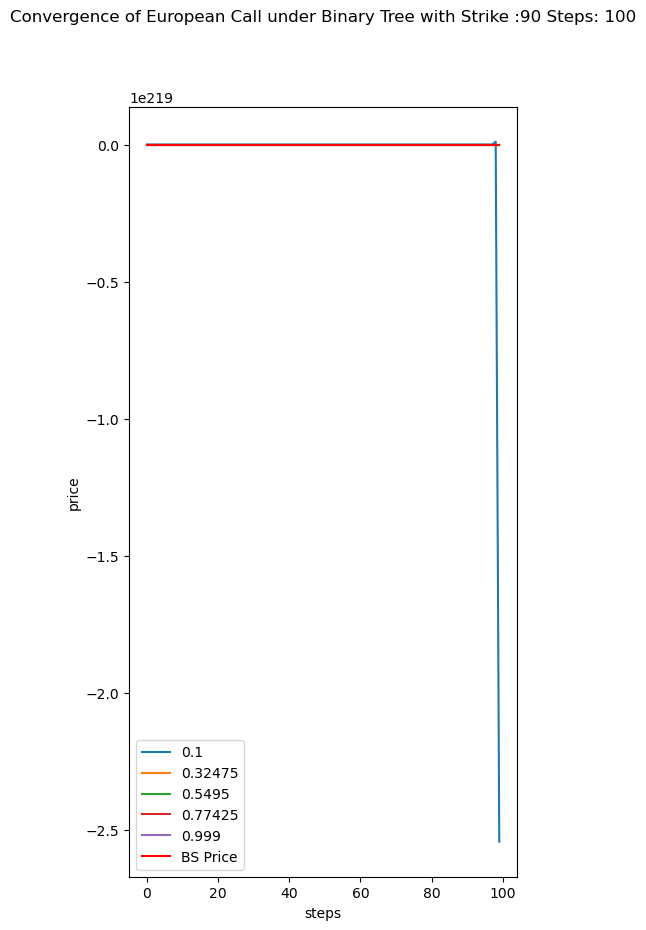

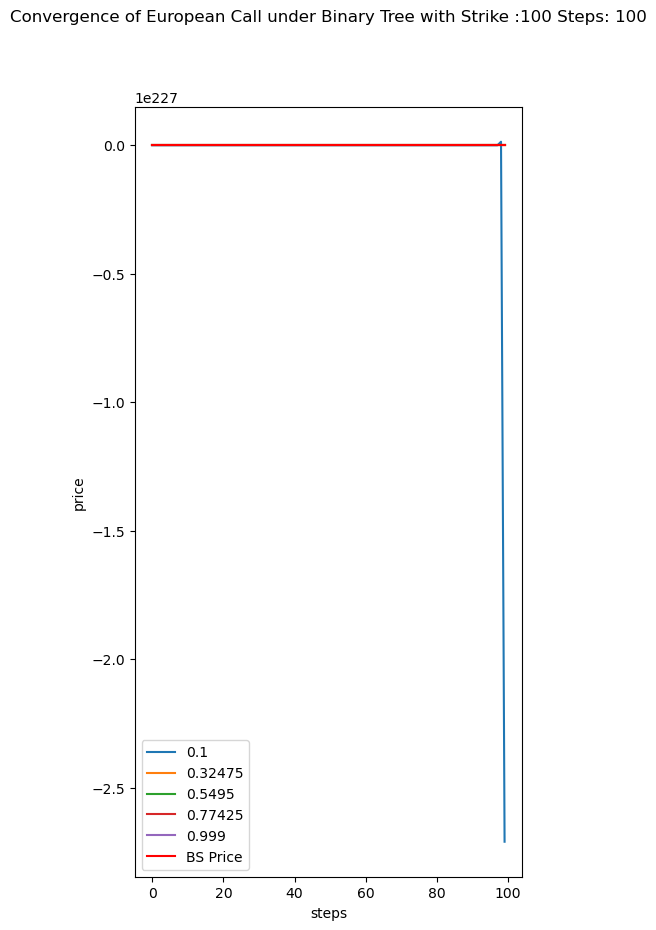

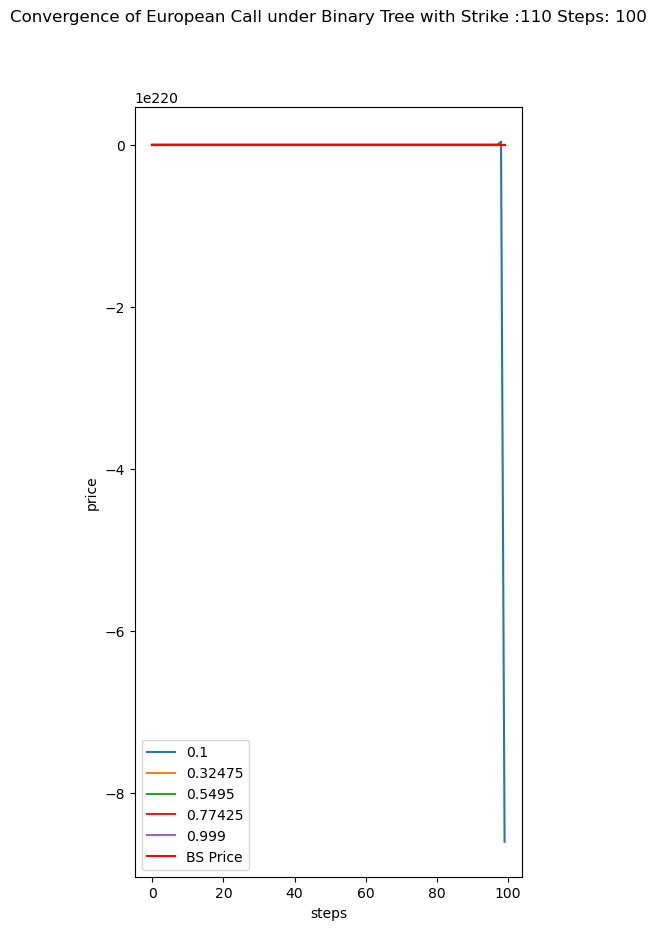

In [10]:
lambs2 = np.linspace(0.1,0.999,5)
step = 100
tri_plot(S0,K,r,sigma,step,T,lambs2 )
tri_plot(S0,100,r,sigma,step,T,lambs2 )
tri_plot(S0,110,r,sigma,step,T,lambs2 )

### Findings
#### Trinomial trees give extremely huge values compared with BS's price, which are definitely wrong.

# Exercise 6: American option under binary tree and trinomial tree


# Binomial tree for Pricing American Option

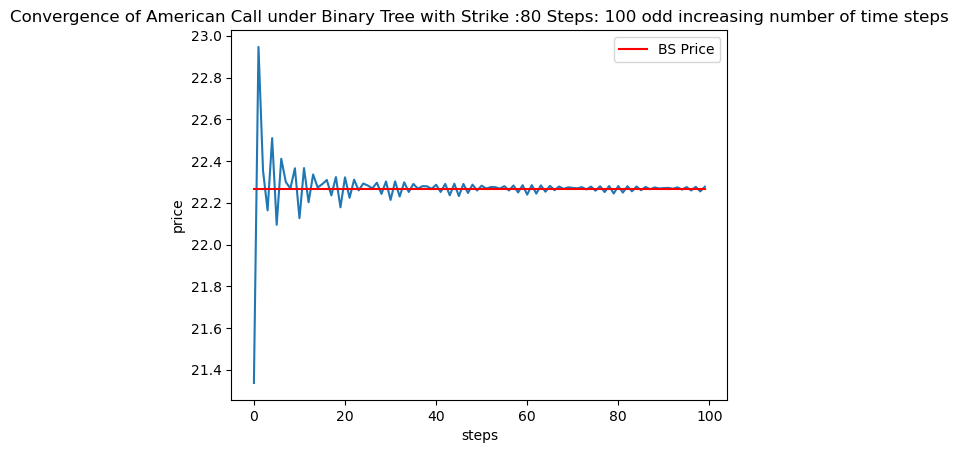

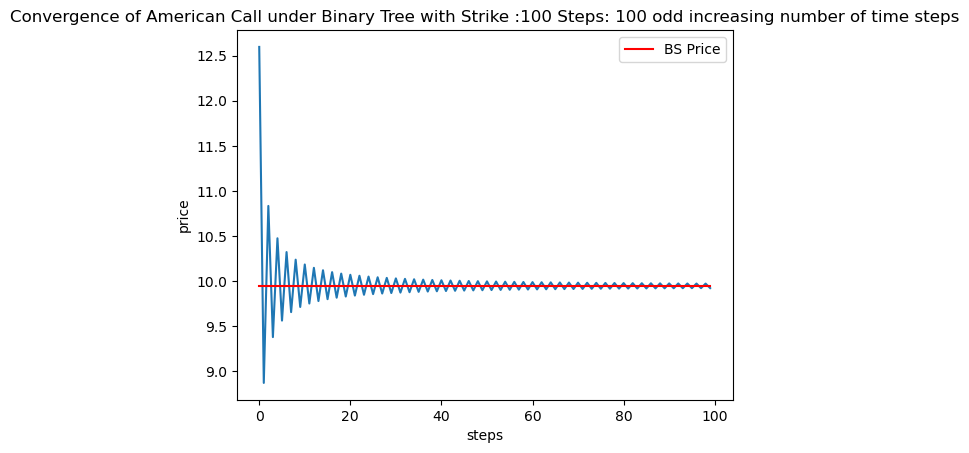

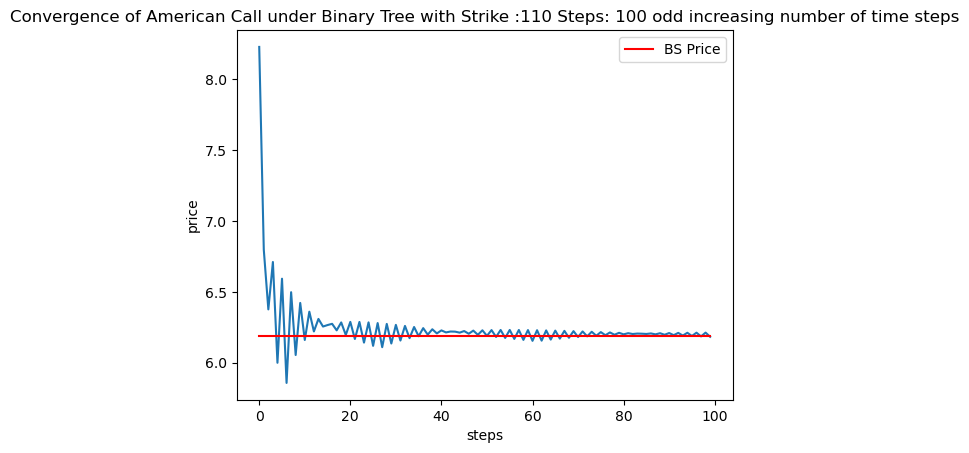

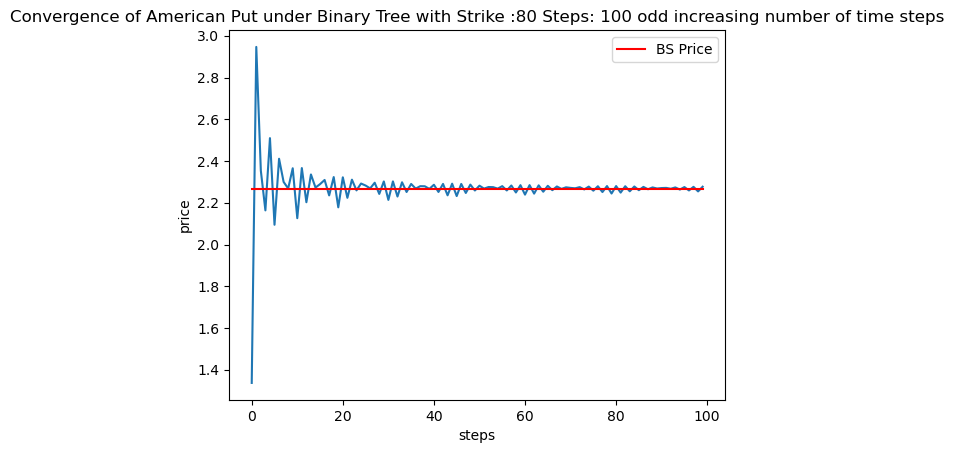

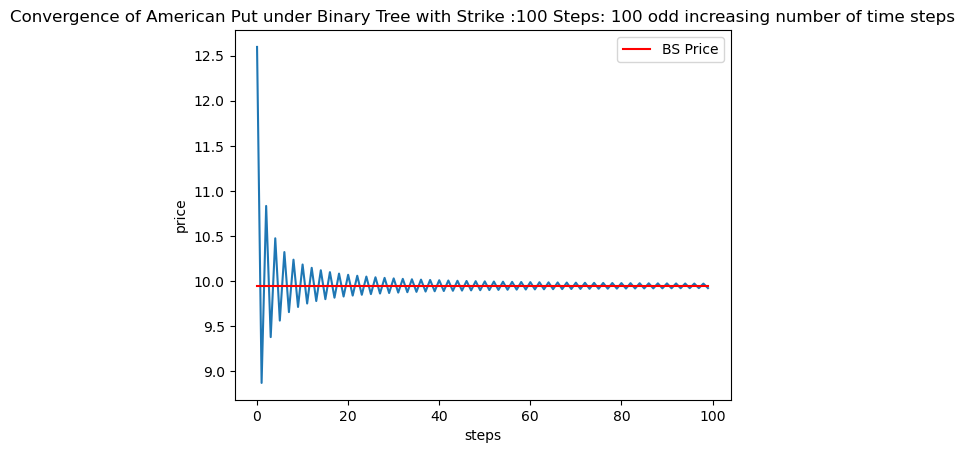

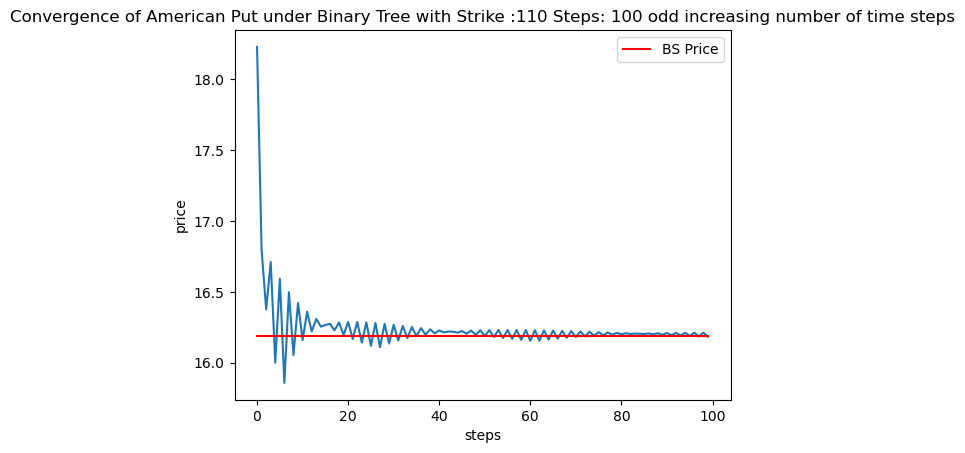

In [11]:
step = 100
K = 80
S0 = 100
r = 0
#Call
cal_plot(S0,K,r,sigma,step,T,call_bool=True,greeks='',type='American',info_str=' odd increasing number of time steps')
cal_plot(S0,100,r,sigma,step,T,call_bool=True,greeks='',type='American',info_str=' odd increasing number of time steps')
cal_plot(S0,110,r,sigma,step,T,call_bool=True,greeks='',type='American',info_str=' odd increasing number of time steps')
#Put
cal_plot(S0,K,r,sigma,step,T,call_bool=False,greeks='',type='American',info_str=' odd increasing number of time steps')
cal_plot(S0,100,r,sigma,step,T,call_bool=False,greeks='',type='American',info_str=' odd increasing number of time steps')
cal_plot(S0,110,r,sigma,step,T,call_bool=False,greeks='',type='American',info_str=' odd increasing number of time steps')

#### When discount rate r = 0, Binomial tree gives same price for American Option as European Option as the discounted value of t+1 th step equals the value when exercised as t th step.

# Trinomical Tree

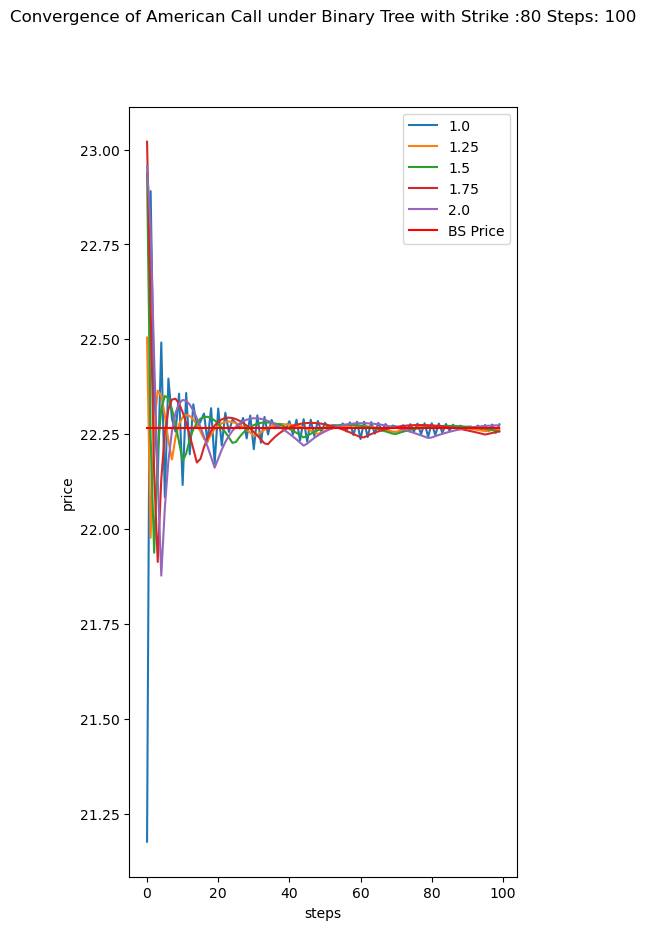

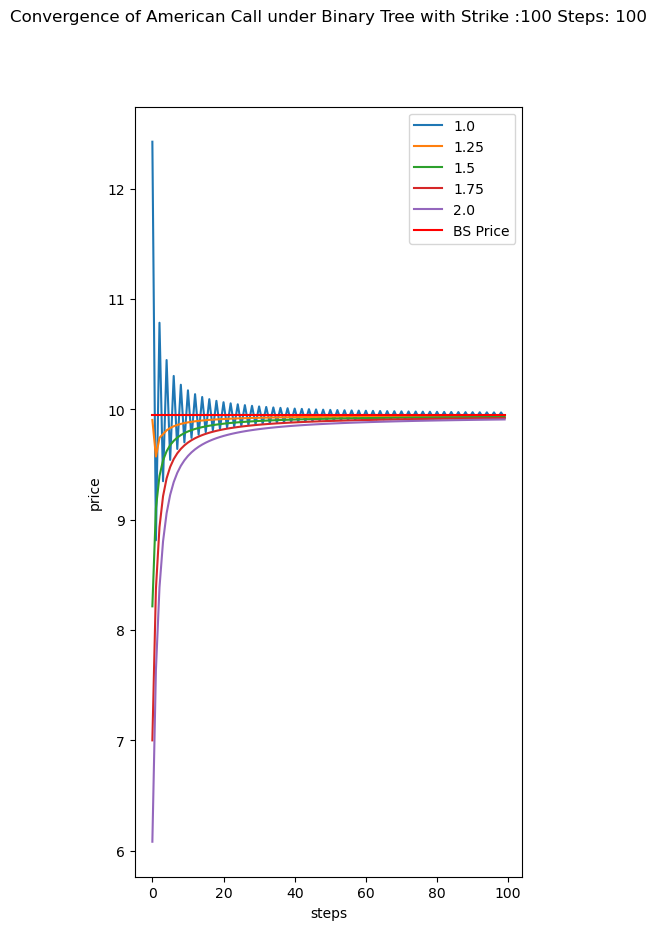

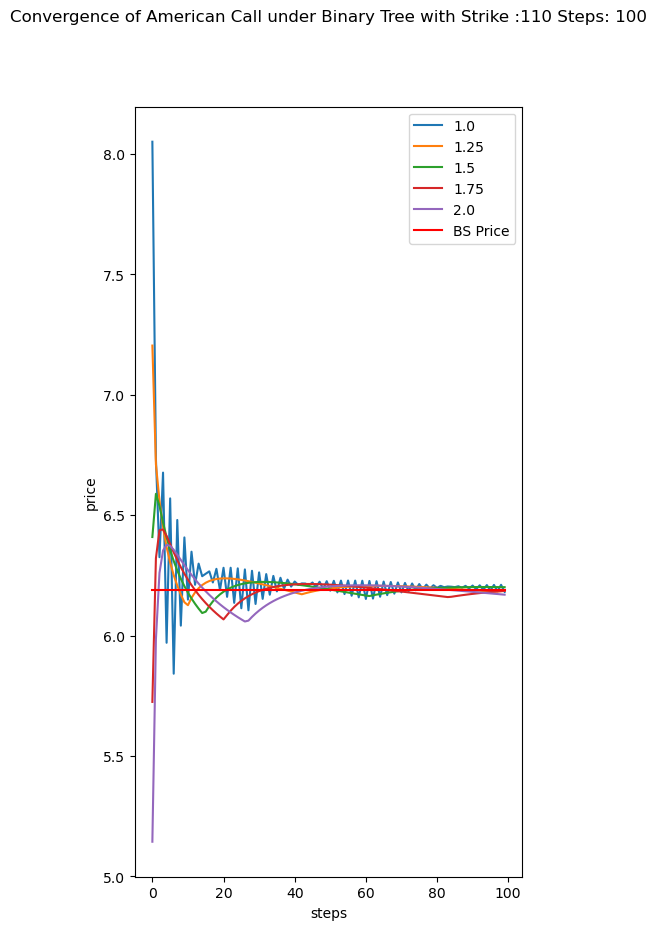

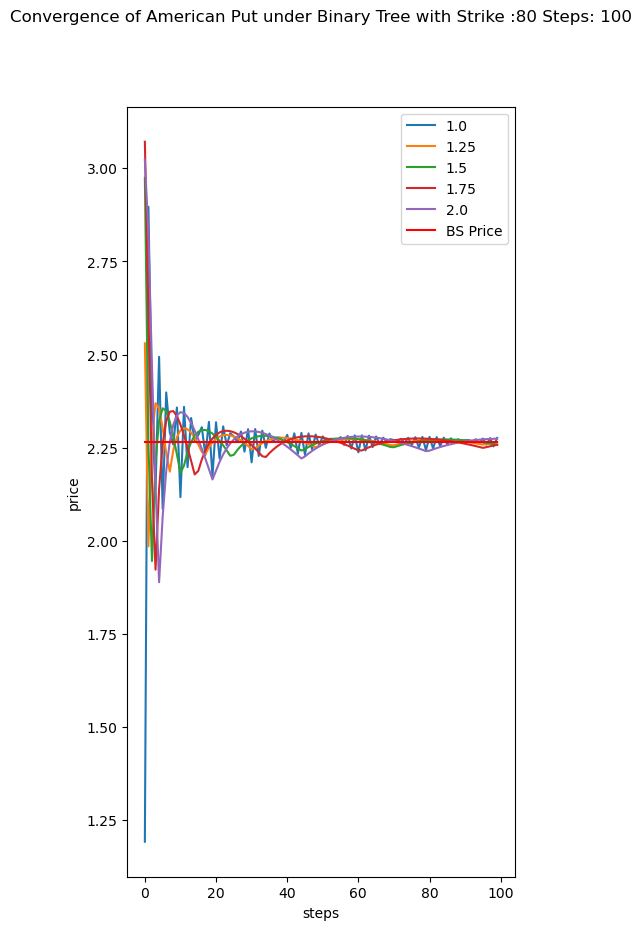

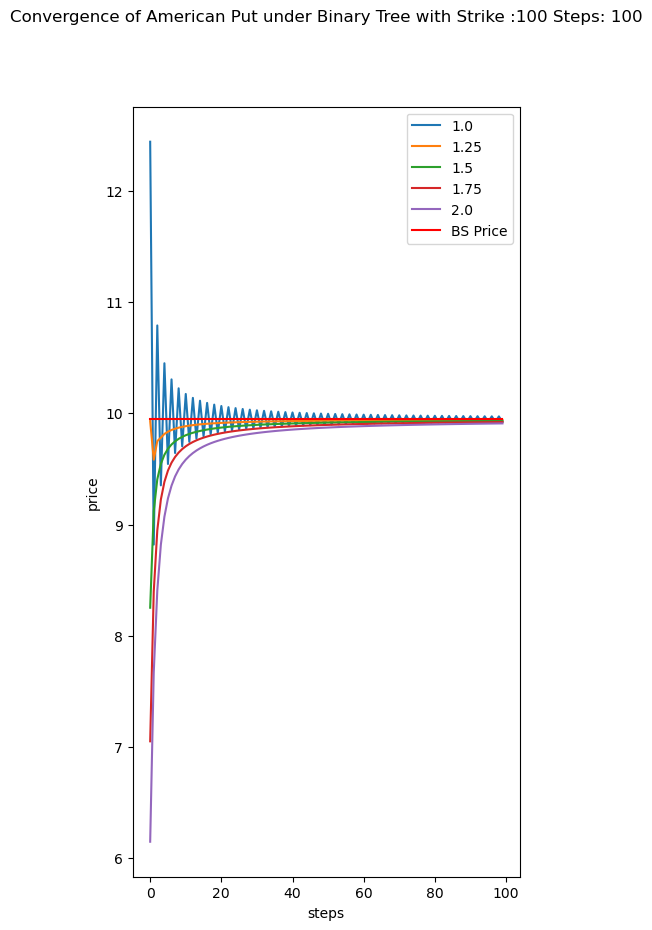

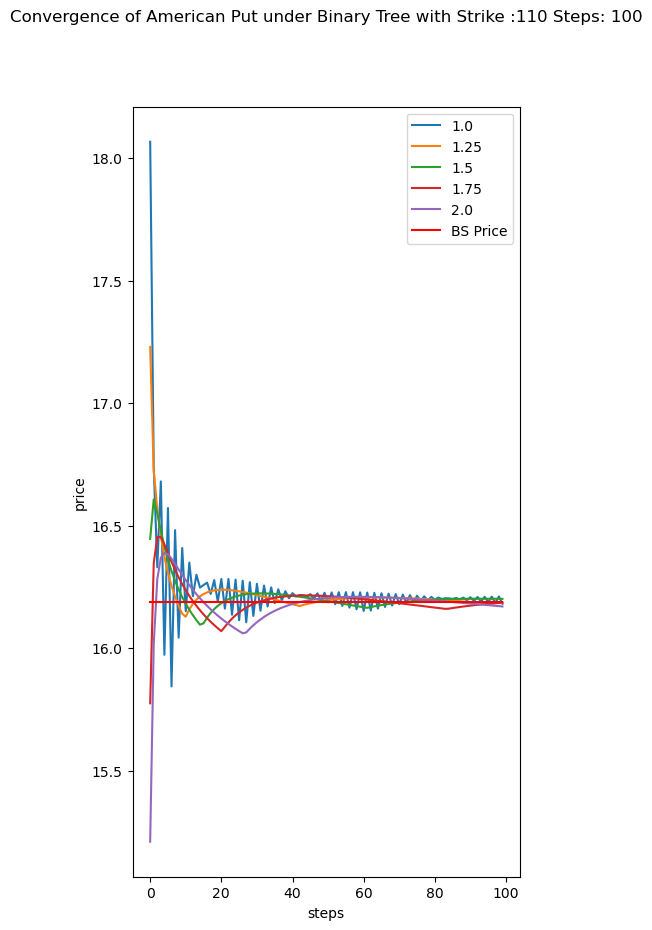

In [12]:

step = 100
tri_plot(S0,K,r,sigma,step,T,lambs,greeks='',type='American')
tri_plot(S0,100,r,sigma,step,T,lambs,greeks='',type='American')
tri_plot(S0,110,r,sigma,step,T,lambs,greeks='',type='American')

tri_plot(S0,K,r,sigma,step,T,lambs,call_bool=False,greeks='',type='American')
tri_plot(S0,100,r,sigma,step,T,lambs,call_bool=False,greeks='',type='American')
tri_plot(S0,110,r,sigma,step,T,lambs,call_bool=False,greeks='',type='American')

#### In Trinomial tree, when $\lambda > 1$, the smaller $\lambda$ , the less volatile it will be in different steps and faster it converges.
#### When $\lambda = 1$, it becomes binomial tree.
